In [1]:
import numpy as np
import pandas as pd
import os  # To handle file paths

# Adjust the path to the actual location of your files
folder_path = 'anusha_f1'

# Reading necessary CSV files
circuits = pd.read_csv(os.path.join(folder_path, 'circuits.csv'), encoding='utf-8', usecols=[0, 1])
constructor_results = pd.read_csv(os.path.join(folder_path, 'constructor_results.csv'), encoding='utf-8', usecols=[0, 1])
constructor_standings = pd.read_csv(os.path.join(folder_path, 'constructor_standings.csv'), encoding='utf-8', usecols=[2, 1, 3, 4, 6])
drivers = pd.read_csv(os.path.join(folder_path, 'drivers.csv'), encoding='utf-8', usecols=[0, 2, 4])
driver_standings = pd.read_csv(os.path.join(folder_path, 'driver_standings.csv'), encoding='utf-8', usecols=[0, 1, 2, 3, 4])
lap_times = pd.read_csv(os.path.join(folder_path, 'lap_times.csv'), encoding='utf-8', usecols=[0, 1, 2, 5])
pit_stops = pd.read_csv(os.path.join(folder_path, 'pit_stops.csv'), encoding='utf-8', usecols=[0, 1, 2, 3, 6])
races = pd.read_csv(os.path.join(folder_path, 'races.csv'), encoding='utf-8', usecols=[0, 1, 3, 4])
results = pd.read_csv(os.path.join(folder_path, 'results.csv'), encoding='utf-8', usecols=[0, 1, 2, 3, 5, 6, 12, 14])

# Merging lap times with pit stops data
lap_pit = pd.merge(lap_times, pit_stops, on=['raceId', 'driverId', 'lap'], how='left')

# Renaming columns
lap_pit.columns = np.where(lap_pit.columns == 'milliseconds_x', 'lap_time', lap_pit.columns)
lap_pit.columns = np.where(lap_pit.columns == 'milliseconds_y', 'pitstop_time', lap_pit.columns)

# Merging results with lap times
result_lap_pit = pd.merge(results, lap_times, on=['raceId', 'driverId'], how='right')

# Merging race results with race information
race_result_lap_pit = pd.merge(results, races, on=['raceId'], how='left')

# Merging drivers into the race data
driver_race_result_lap_pit = pd.merge(race_result_lap_pit, drivers, on=['driverId'], how='left')

# Merging circuits information into the race data
circuit_driver_race_result_lap_pit = pd.merge(driver_race_result_lap_pit, circuits, on=['circuitId'], how='left')

# Convert the final DataFrame to save and check the shape
df = pd.DataFrame(circuit_driver_race_result_lap_pit)

# Save the cleaned dataset in the same folder where the other CSV files are present
output_path = os.path.join(folder_path, 'final_f1.csv')
df.to_csv(output_path, index=False)

print(f"CSV saved successfully to {output_path}")


CSV saved successfully to anusha_f1\final_f1.csv


Evaluating Linear Regression...
Linear Regression Mean Absolute Error: 1.8999837420580654
Linear Regression Root Mean Squared Error: 2.5122071594487076
Linear Regression R^2 Score: 0.5984147704057046


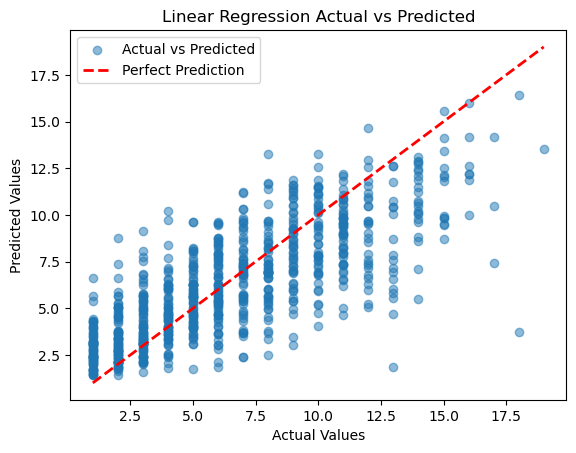

Evaluating Lasso Regression...
Lasso Regression Mean Absolute Error: 1.8991886560983167
Lasso Regression Root Mean Squared Error: 2.5105028139534245
Lasso Regression R^2 Score: 0.5989594769229819


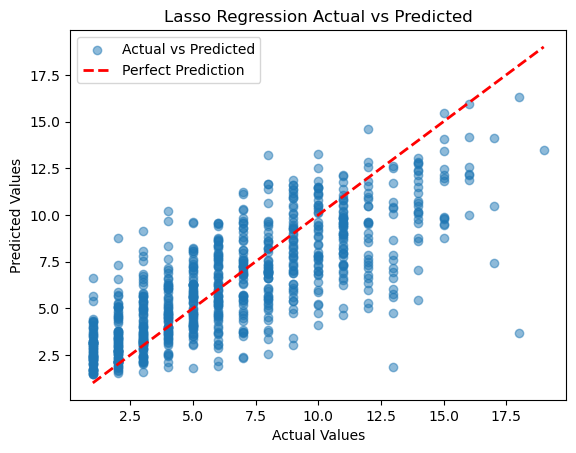

Evaluating Ridge Regression...
Ridge Regression Mean Absolute Error: 1.900719455879246
Ridge Regression Root Mean Squared Error: 2.5123707881555033
Ridge Regression R^2 Score: 0.5983624554431209


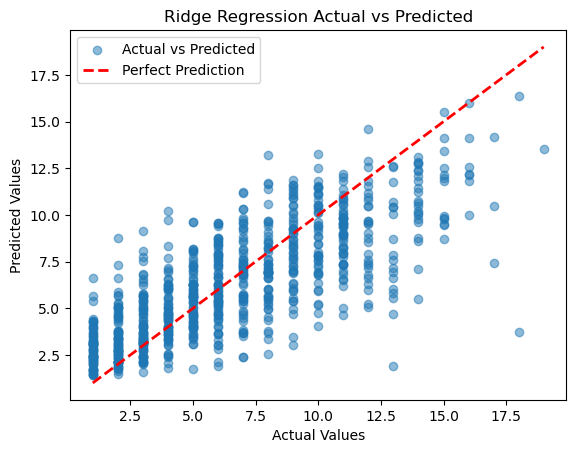

Evaluating Random Forest...
Random Forest Mean Absolute Error: 1.803817890022236
Random Forest Root Mean Squared Error: 2.405188654880741
Random Forest R^2 Score: 0.6319005857726696


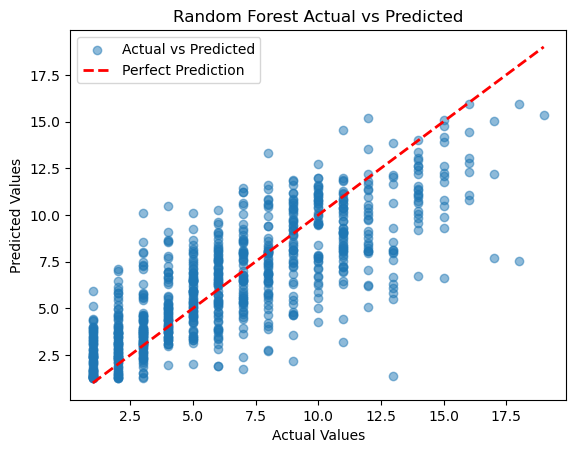

Evaluating XGBoost Regressor...
XGBoost Regressor Mean Absolute Error: 1.791050935326669
XGBoost Regressor Root Mean Squared Error: 2.3830234193606232
XGBoost Regressor R^2 Score: 0.6386538316298165


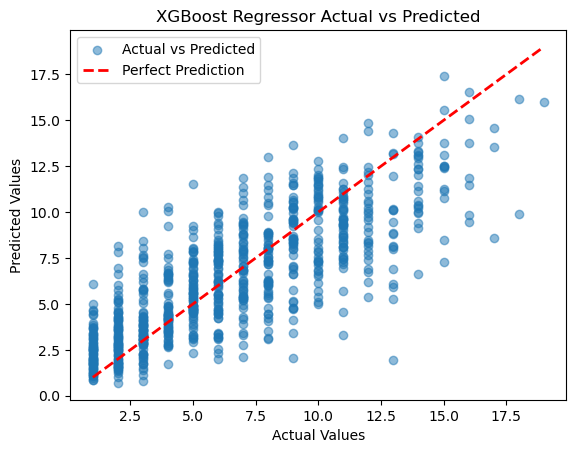

Evaluating SVR...
SVR Mean Absolute Error: 1.8399129425513128
SVR Root Mean Squared Error: 2.521700761953426
SVR R^2 Score: 0.5953738633638359


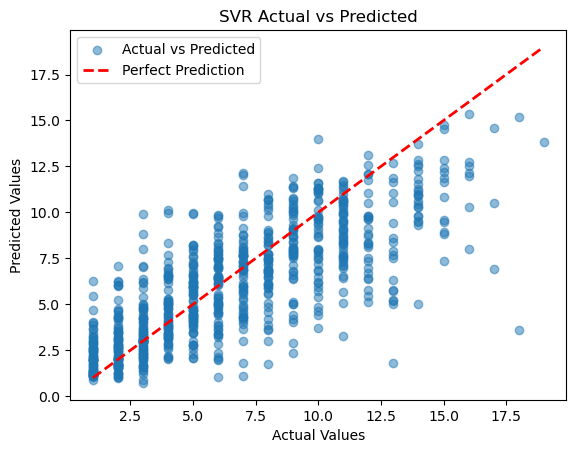

Best model: XGBoost Regressor with R² score: 0.6386538316298165
Predicted Positions for Drivers:
Max: Predicted Position - 1.24
Perez: Predicted Position - 2.76
Ham: Predicted Position - 6.00
Russ: Predicted Position - 5.72
Lec: Predicted Position - 3.16
Saiz: Predicted Position - 8.36
Yuki: Predicted Position - 11.87
Ric: Predicted Position - 10.10


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import os  # To handle file paths

# Adjust the path to the actual location of your files
folder_path = 'anusha_f1'

# Reading the cleaned CSV file
df = pd.read_csv(os.path.join(folder_path, 'final_f1.csv'))

# Clean the 'position' column by replacing '\\N' with NaN
df['position'].replace('\\N', np.nan, inplace=True)

# Clean the 'milliseconds' and 'rank' columns
df['milliseconds'].replace('\\N', np.nan, inplace=True)
df['rank'].replace('\\N', np.nan, inplace=True)

# Drop rows where 'position', 'milliseconds', or 'rank' is NaN
df.dropna(subset=['position', 'milliseconds', 'rank'], inplace=True)

# Convert 'position', 'milliseconds', and 'rank' to numeric
df['position'] = pd.to_numeric(df['position'], errors='coerce')
df['milliseconds'] = pd.to_numeric(df['milliseconds'], errors='coerce')
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')

# Drop remaining rows with NaN values after the conversion
df.dropna(inplace=True)

# Prepare the dataset for model building
X = df.drop(['resultId', 'position', 'year', 'circuitRef', "name", "number", "forename"], axis=1)
y = df['position']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Calculate metrics
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)

    print(f"{model_name} Mean Absolute Error: {mae}")
    print(f"{model_name} Root Mean Squared Error: {rmse}")
    print(f"{model_name} R^2 Score: {r2}")

    # Plotting actual vs predicted values
    plt.scatter(y_test, predictions, alpha=0.5, label='Actual vs Predicted')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
    plt.title(f'{model_name} Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

    return r2

# Hyperparameter tuning for models

# 1. Linear Regression
linear_model = LinearRegression()

# 2. Lasso Regression (using GridSearchCV to tune alpha)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_model = GridSearchCV(Lasso(), param_grid=lasso_params, cv=5)

# 3. Ridge Regression (using GridSearchCV to tune alpha)
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
ridge_model = GridSearchCV(Ridge(), param_grid=ridge_params, cv=5)

# 4. Random Forest Regressor (using GridSearchCV to tune n_estimators and max_depth)
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=rf_params, cv=5)

# 5. XGBoost Regressor (using GridSearchCV to tune max_depth, learning_rate, and n_estimators)
xgb_params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
xgb_model = GridSearchCV(XGBRegressor(), param_grid=xgb_params, cv=5)

# 6. SVR (using GridSearchCV to tune C and kernel)
svr_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
svr_model = GridSearchCV(SVR(), param_grid=svr_params, cv=3)

# Models
models = {
    'Linear Regression': linear_model,
    'Lasso Regression': lasso_model,
    'Ridge Regression': ridge_model,
    'Random Forest': rf_model,
    'XGBoost Regressor': xgb_model,
    'SVR': svr_model
}

# Evaluate all models and store R² scores
model_performance = {}
for name, model in models.items():
    print(f"Evaluating {name}...")
    r2_score_val = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)
    model_performance[name] = r2_score_val

# Find the best model based on R² score
best_model_name = max(model_performance, key=model_performance.get)
print(f"Best model: {best_model_name} with R² score: {model_performance[best_model_name]}")

# Predicting on new dataset (Predict2024) using the best model
best_model = models[best_model_name]
best_model.fit(X_train_scaled, y_train)

# Predicting for new data
Predict2024 = pd.DataFrame([[1121, 830, 9, 1, 5514067, 1, 3],
                            [1121, 815, 9, 4, 5614067, 2, 3],
                            [1121, 1, 131, 6, 5414067, 10, 3],
                            [1121, 847, 131, 7, 5314067, 7, 3],
                            [1121, 844, 6, 2, 4714067, 8, 3],
                            [1121, 832, 6, 5, 5114067, 17, 3],
                            [1121, 852, 213, 15, 5914067, 16, 3],
                            [1121, 817, 213, 13, 5414067, 11, 3]], columns=X.columns)

# Scale the new data before prediction
Predict2024_scaled = scaler.transform(Predict2024)

# Predicting positions for the new data
predictions_new = best_model.predict(Predict2024_scaled)

# Display predictions for the new dataset (Predict2024)
driver_name = ["Max", "Perez", "Ham", "Russ", "Lec", "Saiz", "Yuki", "Ric"]
results = zip(driver_name, predictions_new)

# Print predictions for each driver
print("Predicted Positions for Drivers:")
for driver, prediction in results:
    print(f"{driver}: Predicted Position - {prediction:.2f}")
